Here we implement karpathy's makemore lecture 3 in which we create a multi layer perceptron NN, but use it to predict the next character in a sequence of household electricity demand rather than names.

Here we build on the bigram model, and use more input characters to predict the next character. So like Karpathy, we are building a 'character' level model, but the characters here are string representations of numeric data, in this case numbers in a time-series corresponding to household-level electricity demand profiles.

And so here one of the features of the MLP we are developing is that it will use an embedding layer. So this transforms the inputs, which are sequences of characters first into sequences of embeddings, which are essentially vectors. The reason why this is useful is if you encounter a sequence of characters that are not in the training data. if that happened then you might simply not have any examples that you can train your network on, and then you might end up with a scenario that you can't predict the next sequence, or at least do a very bad job of predicting the next (e.g. just random guess). By using an embedding layer you can get around this if you have other sequences in the traiing data that are at least similar semantically to the 'unknown' sequence.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# read in the sequences of demand profiles
data = open('../data/data.txt','r').read().splitlines()
data[:8]

['<M> <M> <M> <M> <M> <M> <M> <M> <M> <M> 1.0 2.0 4.0 4.0 4.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 1.0 2.0 7.0 4.0 4.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 2.0 1.0 3.0 6.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 8.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 4.0 1.0 7.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0']

In [12]:
# now we want to create the mapping from string to indices
chars = []
chars.append('<S>') # start token
# Define your order
order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0']
for i in order:
    chars.append(i)
chars.append('<M>') #<- missing token
chars.append('<E>') # end token
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
itos

{0: '<S>',
 1: '0.0',
 2: '1.0',
 3: '2.0',
 4: '3.0',
 5: '4.0',
 6: '5.0',
 7: '6.0',
 8: '7.0',
 9: '8.0',
 10: '9.0',
 11: '10.0',
 12: '11.0',
 13: '12.0',
 14: '13.0',
 15: '14.0',
 16: '15.0',
 17: '16.0',
 18: '17.0',
 19: '18.0',
 20: '19.0',
 21: '20.0',
 22: '<M>',
 23: '<E>'}

In [24]:
data[0].split(' ') + ['<E>']

['<M>',
 '<M>',
 '<M>',
 '<M>',
 '<M>',
 '<M>',
 '<M>',
 '<M>',
 '<M>',
 '<M>',
 '1.0',
 '2.0',
 '4.0',
 '4.0',
 '4.0',
 '1.0',
 '1.0',
 '1.0',
 '1.0',
 '2.0',
 '1.0',
 '2.0',
 '1.0',
 '1.0',
 '<E>']

In [106]:
# build the dataset
block_size = 3 # this is the context length aka the number of characters we used to predict the next in sequence
X, Y = [], []
for s in data:
    #print(s)
    context = [0] * block_size
    for ch in s.split(' ') + ['<E>']:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(' '.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [107]:
X.shape, X.dtype, Y.shape, Y.dtype, len(chars)

(torch.Size([16850, 3]), torch.int64, torch.Size([16850]), torch.int64, 24)

In [40]:
# now we create our embeddings layer C. We have 24 characters, and we will embed into 2 dimensions.
C = torch.randn([24,2])
C

tensor([[-0.1126, -0.8021],
        [-1.4446, -0.3675],
        [-0.4597, -0.3837],
        [ 0.9669, -0.3622],
        [-0.0620, -0.4851],
        [-1.3226, -0.2220],
        [-0.2820,  0.8055],
        [ 0.7271, -1.1718],
        [-0.8940,  0.8121],
        [ 0.8044,  0.4486],
        [-0.4913,  1.2040],
        [ 0.7649, -1.4177],
        [-0.5494,  0.3816],
        [-0.5795,  0.6150],
        [-1.5451, -0.2215],
        [-1.7267,  0.1914],
        [-0.0751,  0.6283],
        [-1.4276, -1.3594],
        [-1.2029, -0.0674],
        [-0.6495, -1.3750],
        [ 0.3726,  0.8359],
        [-0.0736, -0.5038],
        [ 0.3972, -0.3662],
        [ 0.2654,  0.8444]])

In [41]:
C[5]

tensor([-1.3226, -0.2220])

In [44]:
F.one_hot(torch.tensor([5]), num_classes=24).float() @ C

tensor([[-1.3226, -0.2220]])

In [47]:
xenc = F.one_hot(X, num_classes=24)
xenc.shape

torch.Size([75, 3, 24])

In [50]:
(xenc.float() @ C).shape

torch.Size([75, 3, 2])

And so the interpretation here is that this first layer C, is like a first layer of the neural network, that is linear, it takes the 3 sets of inputs, one for each character, these consisting each of 24 input neurons, and matrix multiplies them by the C matrix, which is like the W weights matrix, to result in the output of the embedding layer.

Currently we're just using a dimension of 2, but we could have more dimensions clearly. 

In [52]:
C[X].shape

torch.Size([75, 3, 2])

In [53]:
emb = C[X]
emb.shape

torch.Size([75, 3, 2])

Now we've got the embedding layer, and we feed this into the hidden layer. 

In [58]:
# initialise the weights
W1 = torch.randn([6, 100])
b1 = torch.randn([100])

In [64]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([75, 100])

And now finally we have the final layer.

In [72]:
W2 = torch.randn([100, 24])
b2 = torch.randn([24])
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [73]:
# now we want to compute the loss, which means pulling out the probabilities the net assigned to the target characters
loss = -probs[torch.arange(75), Y].log().mean()
loss

tensor(11.2573)

In [74]:
# we can instead simply use the built-in cross-entropy loss
F.cross_entropy(logits, Y)

tensor(11.2573)

In [211]:
# let's put this all together
# let's create the training, dev and test sets
def build_dataset(data):
    block_size = 3 # this is the context length aka the number of characters we used to predict the next in sequence
    X, Y = [], []
    for s in data:
        #print(s)
        context = [0] * block_size
        for ch in s.split(' ') + ['<E>']:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(' '.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(data)
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])



torch.Size([13475, 3]) torch.Size([13475])
torch.Size([1675, 3]) torch.Size([1675])
torch.Size([1700, 3]) torch.Size([1700])


In [273]:
# the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([24,10], generator=g, requires_grad=True)
W1 = torch.randn([30, 200], generator=g, requires_grad=True)
b1 = torch.randn([200], generator=g, requires_grad=True)
W2 = torch.randn([200, 24], generator=g, requires_grad=True)
b2 = torch.randn([24], generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [252]:
sum(p.nelement() for p in parameters)

11264

In [201]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [274]:
# lri = []
iterations = []
lossi = []


In [275]:

for i in range(200000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # the forward pass
    emb = C[X[ix]] # 75, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 75, 100
    logits = h @ W2 + b2 # 75, 24
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i < 100000:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    iterations.append(i)
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
print(loss.item())

1.5299150943756104


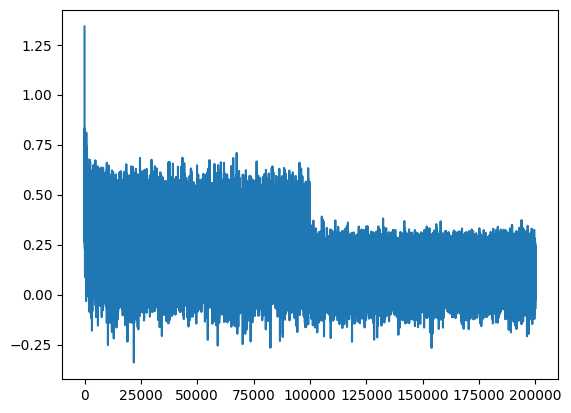

In [276]:
plt.plot(iterations, lossi)

In [277]:
# evaluate the loss over the whole training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

1.8745818138122559


In [278]:
# evaluate the loss over the whole training set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

1.7538994550704956


In [280]:
# now let's sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range (20):
    out = [] 
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if itos[out[-1]] == '<E>':
            break
    print(' '.join(itos[i] for i in out))

2.0 1.0 0.0 2.0 1.0 <E>
1.0 1.0 <M> 0.0 1.0 5.0 3.0 <M> 5.0 6.0 2.0 6.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 <M> 1.0 5.0 1.0 1.0 1.0 <E>
4.0 1.0 1.0 1.0 4.0 1.0 4.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 <M> <E>
1.0 1.0 <M> 0.0 2.0 1.0 1.0 1.0 3.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 <E>
1.0 0.0 1.0 0.0 0.0 1.0 2.0 1.0 <M> 0.0 2.0 1.0 1.0 5.0 1.0 0.0 <E>
1.0 1.0 1.0 0.0 7.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 0.0 1.0 1.0 4.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 3.0 2.0 1.0 <E>
1.0 1.0 1.0 1.0 0.0 1.0 1.0 4.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 5.0 2.0 1.0 1.0 1.0 4.0 1.0 1.0 1.0 1.0 3.0 0.0 1.0 1.0 2.0 4.0 2.0 1.0 2.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 2.0 <M> 1.0 6.0 1.0 5.0 3.0 3.0 1.0 1.0 1.0 1.0 0.0 2.0 2.0 1.0 1.0 6.0 2.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 0.0 2.0 1.0 <E>
2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 2.0 2.0 3.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 <E>
1.0 1.0 2.0 1.0 1.0 4.0 <E>
1.0 1.0 

In [178]:
import numpy as np

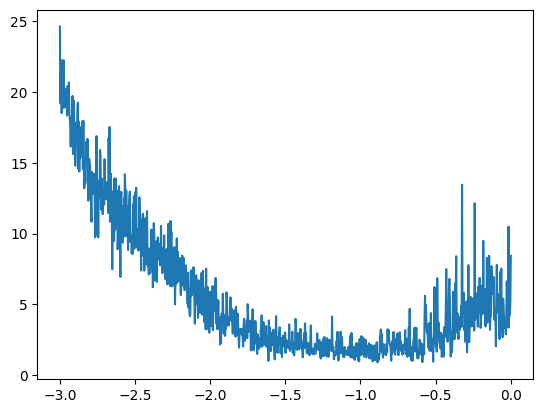

In [198]:
plt.plot(lri, lossi)

So the point of this plot is that we want the highest learning rate possible, as by definition this means that we descend the gradient the fastest possible, but not so large that we start to get into an instable region.

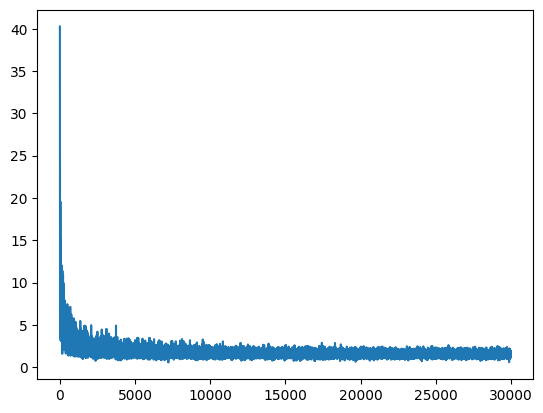

In [232]:
plt.plot(iterations, lossi)

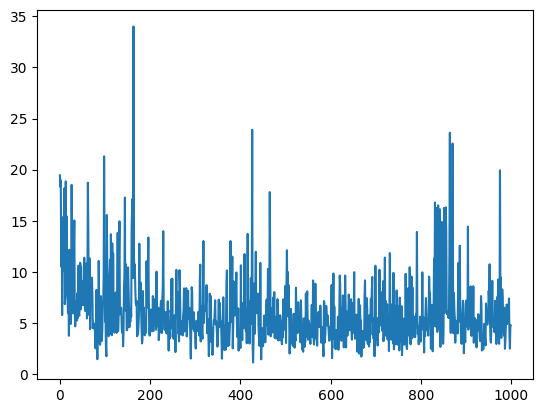

In [195]:
plt.plot(iterations, lossi)

So we can see that we're getting a loss that is better than the bigram loss, which was around 1.25. We're getting a loss around 1.13. 

However, clearly this is just the training loss. And actually we should be using a training, dev/validation, test split. 80%/10%/10%.

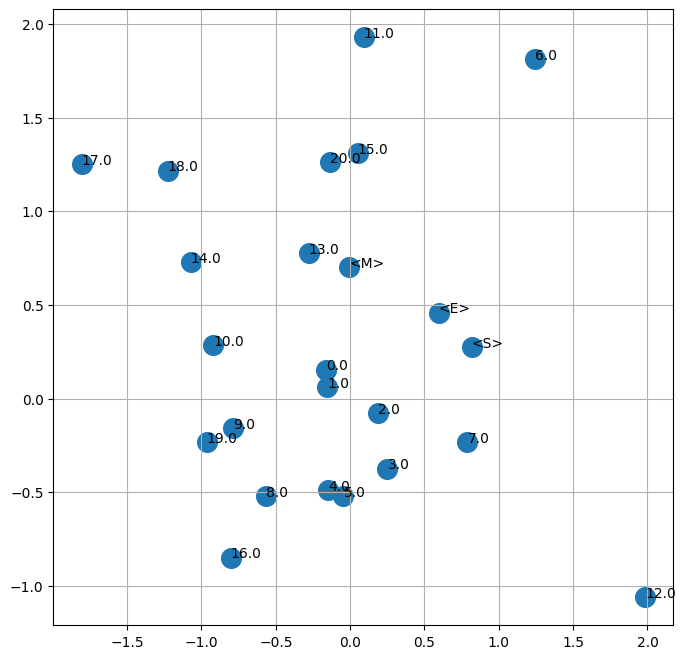

In [250]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i])
plt.grid('minor')

This is not really that meaninful viewing the embeddings. Although actually, 1 2 and 0 are very close to each other. The higher numbers tend to be more isolated.